In [16]:
from IPython.display import HTML, display

In [32]:
display(HTML("""<h2>Two Step Forecasting for weather and kWh delivered (using LSTM)</h2> <p>In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model</p>"""))

In [9]:
# Import necessary packages

In [17]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Dropout

In [11]:
# Load the weather data from the weather data folder

In [18]:
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)


weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

# Select relevant features
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
weather_df = weather_df[weather_features + ['date']]

# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)
weather_daily_df = weather_df.groupby('date').mean().reset_index()


In [13]:
# Select relevant features

In [19]:
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
df = df[features + ['date']]


In [ ]:
# Normalize the data and split into training and testing sets

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for LSTM
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [46]:
# Build an LSTM using the data from the model

In [21]:
input_shape= (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0245
Epoch 2/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0120
Epoch 3/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0108
Epoch 4/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0100
Epoch 5/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0093
Epoch 6/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0089
Epoch 7/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0086
Epoch 8/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0084
Epoch 9/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0082
Epoch 10/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0081
Epoch 11/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0081
Epoch 12/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0079
Epoch 13/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0079
Epoch 14/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0079
Epoch 15/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s

In [17]:
# Evaluate the Model and check for accuracy

In [14]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Temperature - Mean Absolute Error: 2.227341893249088
Temperature - Mean Squared Error: 8.192814908876798
Wind_speed - Mean Absolute Error: 2.949802199204763
Wind_speed - Mean Squared Error: 14.173806860753063
Pressure - Mean Absolute Error: 1.3104495578342015
Pressure - Mean Squared Error: 3.2098504691777956
Humidity - Mean Absolute Error: 9.256279662450154
Humidity - Mean Squared Error: 144.89536019104543
Precip - Mean Absolute Error: 0.11043690426774108
Precip - Mean Squared Error: 0.18860849816935318


In [ ]:
#Plot the results

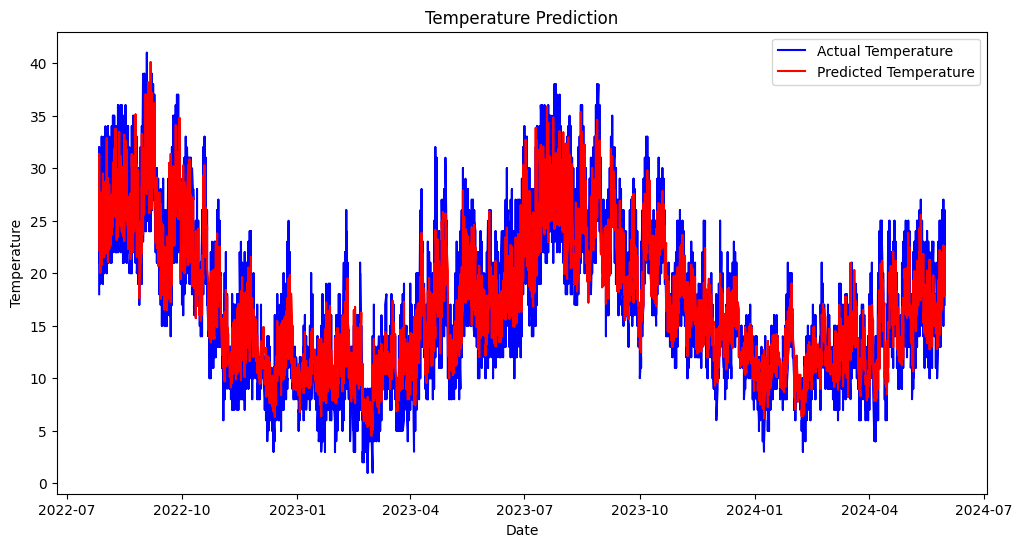

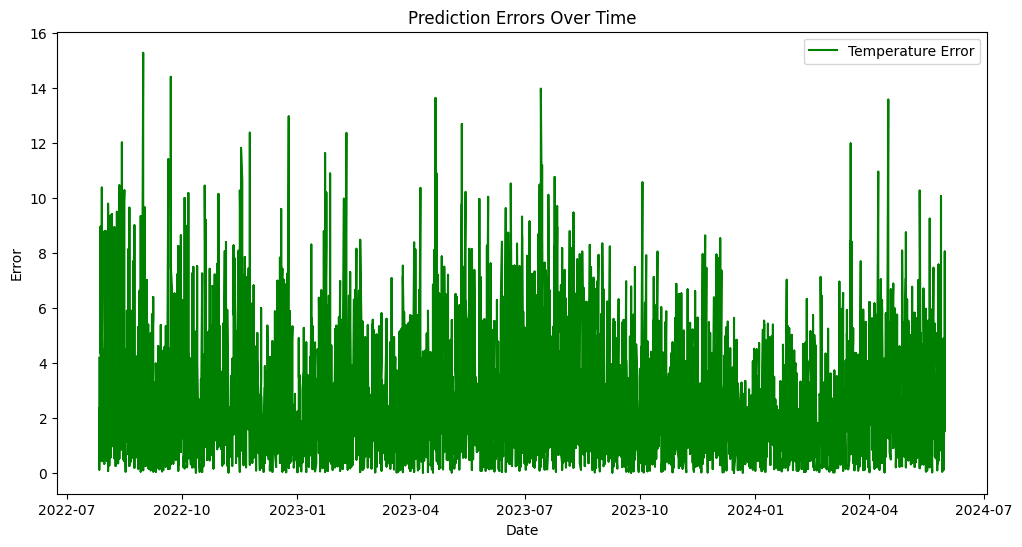

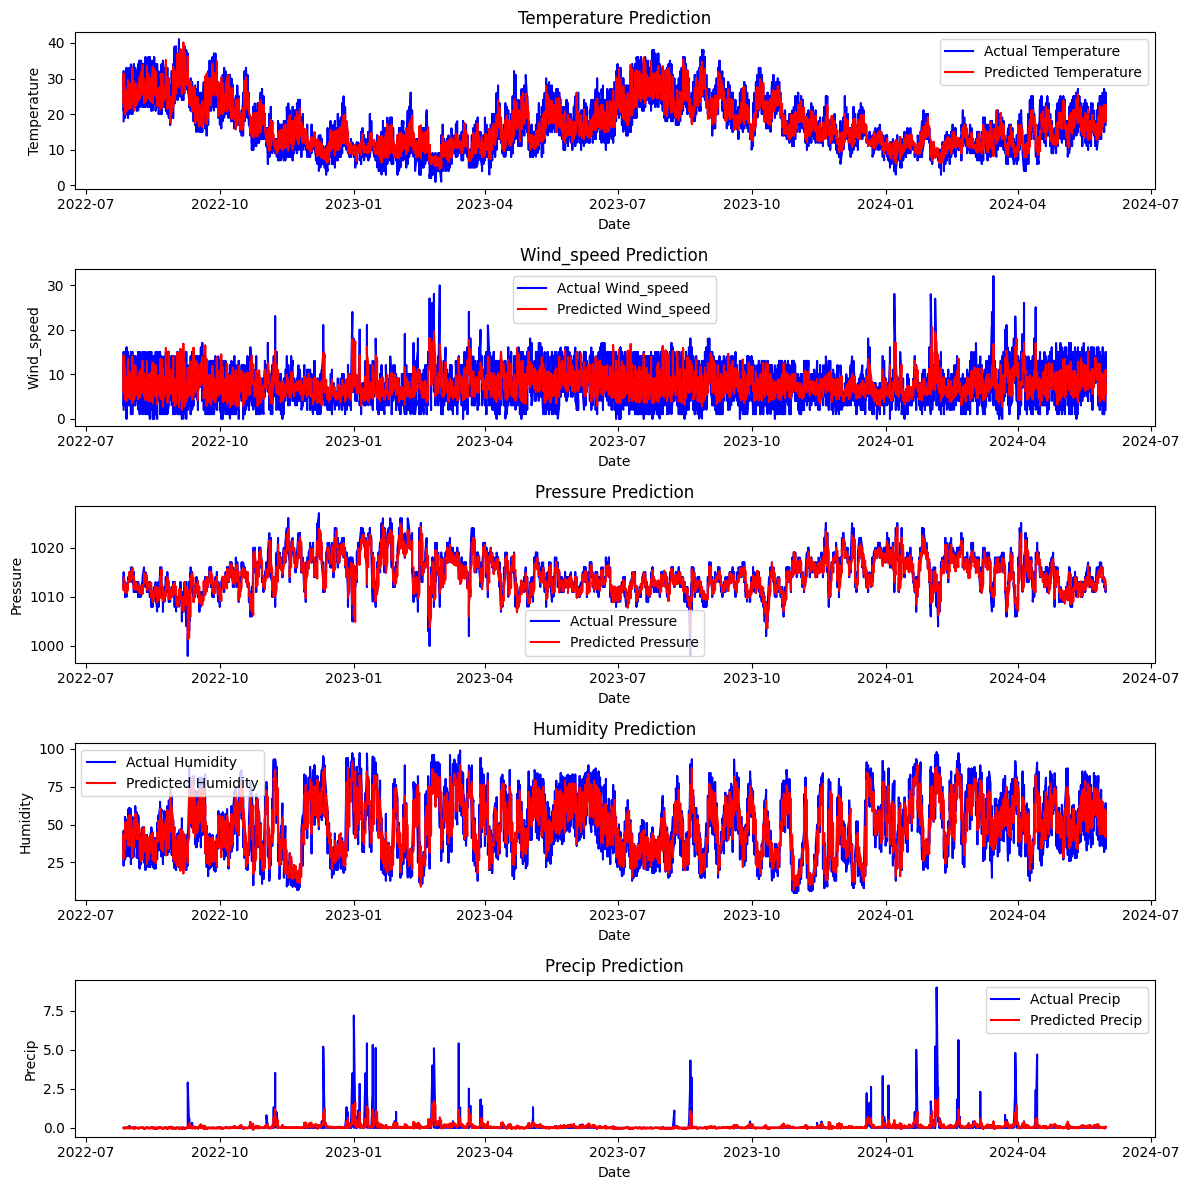

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, 0], color='blue', label='Actual Temperature')
plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, 0], color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot the errors over time
errors = np.abs(y_test_inverse - y_pred_inverse)
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], errors[:, 0], color='green', label='Temperature Error')
plt.title('Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

In [48]:
display(HTML("""<h2>Second step</h2> <p>Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations</p>"""))

In [ ]:
# Load and preprocess the EV charging station data

In [23]:
stations_folder_path = './caltech_stations_data'
stations_data_frames = []

for file_name in os.listdir(stations_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(stations_folder_path, file_name)
        try:
            station_df = pd.read_csv(file_path)
            stations_data_frames.append(station_df)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

ev_data = pd.concat(stations_data_frames, ignore_index=True)
ev_data['date'] = pd.to_datetime(ev_data['month'], format='%Y-%m')
ev_data.drop(columns=['month'], inplace=True)


In [ ]:
# Merge the weather data with the EV charging station data

In [24]:
merged_df = pd.merge(ev_data, weather_daily_df, on='date', how='left')

# Fill missing values (if any) with forward fill method
merged_df.ffill(inplace=True)


In [61]:
# Perform feature engineering

In [25]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

# Create sequences for LSTM
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [63]:
# Build the LSTM and plot the results based on aggregating all stations in a location

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0688
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0369
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0353
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0316
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0299
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0242
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0247
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0236
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0208
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0210
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209
Epoch 13/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197
Epoch 15/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194
Epoc

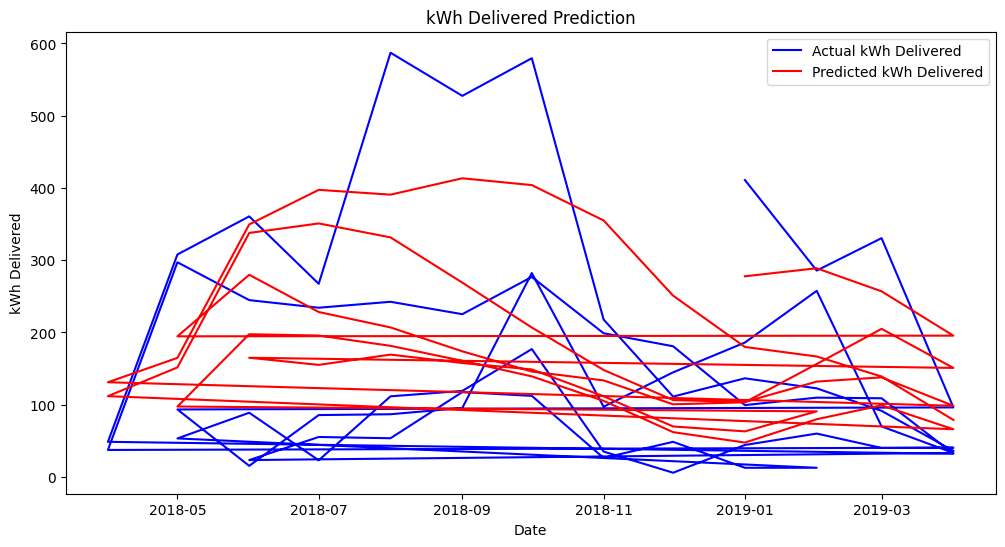

In [97]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1))[:, -1]

# Evaluate the model
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'][train_size+sequence_length:], y_test_inverse, color='blue', label='Actual kWh Delivered')
plt.plot(merged_df['date'][train_size+sequence_length:], y_pred_inverse, color='red', label='Predicted kWh Delivered')
plt.title('kWh Delivered Prediction')
plt.xlabel('Date')
plt.ylabel('kWh Delivered')
plt.legend()
plt.show()

In [81]:
# Build the LSTM and train individually based on stationID

In [28]:
unique_station_ids = ev_data['stationID'].unique()

for station_id in unique_station_ids:
    station_data = ev_data[ev_data['stationID'] == station_id]

    # Merge the weather data with the station-specific data
    merged_df = pd.merge(station_data, weather_daily_df, on='date', how='left')
    merged_df.ffill(inplace=True)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

    # Create sequences for LSTM
    sequence_length = 30
    X = []
    y = []

    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

    X, y = np.array(X), np.array(y)


    # Build and train the LSTM model
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse scale the predictions and actual values
    y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
    y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1))[:, -1]

    # Evaluate the model
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    print(f'Station ID: {station_id} - Mean Absolute Error: {mae}')
    print(f'Station ID: {station_id} - Mean Squared Error: {mse}')

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(merged_df['date'][train_size+sequence_length:], y_test_inverse, color='blue', label='Actual kWh Delivered')
    plt.plot(merged_df['date'][train_size+sequence_length:], y_pred_inverse, color='red', label='Predicted kWh Delivered')
    plt.title(f'Station ID: {station_id} - kWh Delivered Prediction')
    plt.xlabel('Date')
    plt.ylabel('kWh Delivered')
    plt.legend()
    plt.show()

Epoch 1/25


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 6 and 5 for '{{node sequential_4_1/lstm_8_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_4_1/lstm_8_1/strided_slice_2, sequential_4_1/lstm_8_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,6], [5,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 6), dtype=float32)
  • states=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
  • training=True